In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

def fetch_stock_data(symbol, period='1d'):
    return yf.Ticker(symbol).history(period=period)

def fetch_option_expiration_dates(symbol):
    try:
        option_dates = yf.Ticker(symbol).options
        expiration_dates = pd.to_datetime(option_dates).strftime('%Y-%m-%d').tolist()
        return expiration_dates
    except IndexError:
        print("No valid option expiration dates found.")
        return []

def fetch_option_chain(symbol, expiration_date):
    expiration_dates = yf.Ticker(symbol).options

    if expiration_date in expiration_dates:
        try:
            option_chain = yf.Ticker(symbol).option_chain(date=expiration_date)
            if option_chain is None or option_chain.calls.empty or option_chain.puts.empty:
                print("Error: Empty option chain or missing data.")
                return None
            return option_chain
        except Exception as e:
            print(f"Error fetching option chain: {e}")
            return None
    else:
        print(f"Expiration date {expiration_date} is not available.")
        return None

def options_filter(options, current_stock_price, n=10):
    # Find the at-the-money (ATM) option
    atm_option = options.iloc[(options['strike'] - current_stock_price).abs().argsort()[:1]]

    # Get the ATM strike
    atm_strike = atm_option['strike'].values[0]

    # Filter options that are within N strikes away from the ATM strike
    filtered_options = options[(options['strike'] >= atm_strike - n) & (options['strike'] <= atm_strike + n)]

    return filtered_options

def straddle(call_options, put_options, current_stock_price):
    # Find the at-the-money (ATM) call and put options
    atm_call = call_options.iloc[(call_options['strike'] - current_stock_price).abs().argsort()[:1]]
    atm_put = put_options.iloc[(put_options['strike'] - current_stock_price).abs().argsort()[:1]]

    # Get the premium (lastPrice) of the ATM call and put options
    long_call_price = atm_call['lastPrice'].values[0]
    long_put_price = atm_put['lastPrice'].values[0]

    # Exact strike prices without rounding
    long_call_strike = atm_call['strike'].values[0]
    long_put_strike = atm_put['strike'].values[0]

    # Find the index of the closest stock price to the current stock price
    current_price_index = np.argmin(np.abs(stock_prices - current_stock_price))

    return long_call_price, long_put_price, long_call_strike, long_put_strike, current_price_index

def strangle(call_options, put_options, current_stock_price, stock_prices):

    otm_call = options_filter(call_options, current_stock_price, n=10)
    otm_put = options_filter(put_options, current_stock_price, n=10)

    # Choose the call option with the highest implied volatility among the selected OTM options
    otm_call = otm_call[otm_call['strike'] > current_stock_price].nlargest(1, 'impliedVolatility')

    # Choose the put option with the highest implied volatility among the selected OTM options
    otm_put = otm_put[otm_put['strike'] < current_stock_price].nlargest(1, 'impliedVolatility')

    # Get the premium (lastPrice) of the OTM call and put options
    long_call_price = otm_call['lastPrice'].values[0]
    short_put_price = otm_put['lastPrice'].values[0]

    # Exact strike prices without rounding
    long_call_strike = otm_call['strike'].values[0]
    short_put_strike = otm_put['strike'].values[0]

    # Find the index of the closest stock price to the current stock price
    current_price_index = np.argmin(np.abs(stock_prices - current_stock_price))

    return long_call_price, short_put_price, long_call_strike, short_put_strike, current_price_index

def iron_condor(call_options, put_options, current_stock_price, stock_prices):

    # Select out-of-the-money (OTM) call and put options for the Iron Condor
    otm_call = options_filter(call_options, current_stock_price, n=10)
    otm_put = options_filter(put_options, current_stock_price, n=10)

    # Choose the call option with the highest implied volatility among the selected OTM options
    otm_call_ = otm_call[otm_call['strike'] > current_stock_price].nlargest(1, 'impliedVolatility')

    # Choose the put option with the highest implied volatility among the selected OTM options
    otm_put_ = otm_put[otm_put['strike'] < current_stock_price].nlargest(1, 'impliedVolatility')

    # Find the nearest OTM call and put options
    nearest_otm_call = otm_call_.iloc[(otm_call_['strike'] - current_stock_price).abs().argsort()[:1]]
    nearest_otm_put = otm_put_.iloc[(current_stock_price - otm_put_['strike']).abs().argsort()[:1]]

    # Get the premiums (lastPrice) and strike prices of the selected call and put options
    short_call_price = nearest_otm_call['lastPrice'].values[0]
    short_put_price = nearest_otm_put['lastPrice'].values[0]

    # Calculate the short call and put strikes for the Iron Condor
    short_call_strike = nearest_otm_call['strike'].values[0]
    short_put_strike = nearest_otm_put['strike'].values[0]

    # Calculate the long call and put strikes for the Iron Condor
    long_call_strike = short_call_strike + 5
    long_put_strike = short_put_strike - 5

    # Find the second nearest long OTM call and put options
    nearest_long_call = otm_call.iloc[(otm_call['strike'] - (current_stock_price+5)).abs().argsort()[:1]]
    nearest_long_put = otm_put.iloc[(otm_put['strike'] - (current_stock_price-5)).abs().argsort()[:1]]

    # Get the premiums (lastPrice) of the selected long call and put options
    long_call_price = nearest_long_call['lastPrice'].values[0]
    long_put_price = nearest_long_put['lastPrice'].values[0]

    # Find the index of the closest stock price to the current stock price
    current_price_index = np.argmin(np.abs(stock_prices - current_stock_price))

    return long_call_price, long_put_price, short_call_price, short_put_price, long_call_strike, long_put_strike, short_call_strike, short_put_strike, current_price_index

def iron_butterfly(call_options, put_options, current_stock_price, stock_prices):

    # Find the at-the-money (ATM) call and put options
    atm_call = call_options.iloc[(call_options['strike'] - current_stock_price).abs().argsort()[:1]]
    atm_put = put_options.iloc[(put_options['strike'] - current_stock_price).abs().argsort()[:1]]

    # Get the premium (lastPrice) of the ATM call and put options
    short_call_price = atm_call['lastPrice'].values[0]
    short_put_price = atm_put['lastPrice'].values[0]

    # Exact strike prices without rounding
    short_call_strike = atm_call['strike'].values[0]
    short_put_strike = atm_put['strike'].values[0]

    # Select out-of-the-money (OTM) call and put options for the Iron Butterfly
    otm_call = options_filter(call_options, current_stock_price, n=10)
    otm_put = options_filter(put_options, current_stock_price, n=10)

    # Calculate the long call and put strikes for the Iron Butterfly
    long_call_strike = short_call_strike + 5
    long_put_strike = short_put_strike - 5

    # Find the nearest short OTM call and put options
    nearest_long_call = otm_call.iloc[(otm_call['strike'] - (current_stock_price+5)).abs().argsort()[:1]]
    nearest_long_put = otm_put.iloc[(otm_put['strike'] - (current_stock_price-5)).abs().argsort()[:1]]

    # Get the premiums (lastPrice) of the selected short call and put options
    long_call_price = nearest_long_call['lastPrice'].values[0]
    long_put_price = nearest_long_put['lastPrice'].values[0]

    # Find the index of the closest stock price to the current stock price
    current_price_index = np.argmin(np.abs(stock_prices - current_stock_price))

    return long_call_price, long_put_price, short_call_price, short_put_price, long_call_strike, long_put_strike, short_call_strike, short_put_strike, current_price_index

def ratio_call_spread(call_options, current_stock_price, stock_prices, ratio):

    # Select out-of-the-money (OTM) call options for the Ratio Call Spread
    otm_call = options_filter(call_options, current_stock_price, n=10)

    # Choose the call option with the highest implied volatility among the selected OTM options
    otm_call = otm_call[otm_call['strike'] > current_stock_price].nlargest(1, 'impliedVolatility')

    # Find the nearest OTM call option
    nearest_otm_call = otm_call.iloc[(otm_call['strike'] - current_stock_price).abs().argsort()[:1]]

    # Get the premium (lastPrice) and strike price of the selected call option
    long_call_price = nearest_otm_call['lastPrice'].values[0]
    long_call_strike = nearest_otm_call['strike'].values[0]

    # Calculate the short call and long call strikes for the Ratio Call Spread
    short_call_strike = long_call_strike + 5

    # Find the nearest short OTM call and put options
    nearest_long_call = otm_call.iloc[(otm_call['strike'] - long_call_strike).abs().argsort()[:1]]

    # Get the premiums (lastPrice) of the selected short call and put options
    short_call_price = nearest_long_call['lastPrice'].values[0]

    return long_call_price, short_call_price, long_call_strike, short_call_strike

def calculate_payoff2(stock_prices, current_stock_price, long_call_strike, long_put_strike, long_call_price, long_put_price):
    long_call_payoff = np.maximum(stock_prices - long_call_strike, 0) - long_call_price
    long_put_payoff = np.maximum(long_put_strike - stock_prices, 0) - long_put_price
    total_payoff = long_call_payoff + long_put_payoff
    return total_payoff

def calculate_payoff4(stock_prices, current_stock_price, long_call_strike, long_put_strike, short_call_strike, short_put_strike, long_call_price, long_put_price, short_call_price, short_put_price):
    long_call_payoff = np.maximum(stock_prices - long_call_strike, 0) - long_call_price
    long_put_payoff = np.maximum(long_put_strike - stock_prices, 0) - long_put_price
    short_call_payoff = -np.maximum(stock_prices - short_call_strike, 0) + short_call_price
    short_put_payoff = -np.maximum(short_put_strike - stock_prices, 0) + short_put_price
    total_payoff = long_call_payoff + long_put_payoff + short_call_payoff + short_put_payoff
    return total_payoff

def calculate_ratio_call_spread_payoff(stock_prices, current_stock_price, long_call_price, short_call_price, long_call_strike, short_call_strike, ratio):
    short_call_payoff = (-np.maximum(stock_prices - short_call_strike, 0) + short_call_price) * ratio
    long_call_payoff = np.maximum(stock_prices - long_call_strike, 0) - long_call_price
    total_payoff = short_call_payoff + long_call_payoff
    return total_payoff

In [ ]:
# Define the ticker symbol
symbol = input("Enter a ticker symbol: ")

# Fetch stock data
stock_data = fetch_stock_data(symbol)
current_stock_price = (stock_data['Close'].iloc[-1]).round(2)  # Assuming 'Close' column represents the closing prices

# Bullish market scenario
bullish_factor = 1.05  # 5% increase for a bullish market
bullish_future_stock_price = (current_stock_price * bullish_factor).round(2)

# Bearish market scenario
bearish_factor = 0.95  # 5% decrease for a bearish market
bearish_future_stock_price = (current_stock_price * bearish_factor).round(2)

# Choppy market scenario
choppy_factor = 1.00  # No increase for a choppy market
choppy_future_stock_price = (current_stock_price * choppy_factor).round(2)

# Define a range of stock prices for the payoff calculation
stock_prices = np.linspace(current_stock_price - 10, current_stock_price + 10, 1000)

# Print available expiration dates for the chosen ticker
expiration_dates = fetch_option_expiration_dates(symbol)
print("Available Expiration Dates:", expiration_dates)
entry_date = input("Enter the buy date (yyyy-mm-dd): ")
expiry_date = input("Enter the expiry date (yyyy-mm-dd): ")

if expiry_date <= entry_date:
    print(f"Error: Expiry can't be before entry")

# Fetch option chain for the nearest expiration date
ticker_option_chain_entry = fetch_option_chain(symbol, entry_date)

# Extract call and put options data
call_options_entry = ticker_option_chain_entry.calls
put_options_entry = ticker_option_chain_entry.puts

ticker_option_chain_expiry = fetch_option_chain(symbol, expiry_date)
call_options_expiry = ticker_option_chain_expiry.calls
put_options_expiry = ticker_option_chain_expiry.puts

Enter a ticker symbol: spy
Available Expiration Dates: ['2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-29', '2024-01-05', '2024-01-12', '2024-01-19', '2024-01-26', '2024-01-31', '2024-02-16', '2024-02-29', '2024-03-15', '2024-03-28', '2024-04-19', '2024-04-30', '2024-05-31', '2024-06-21', '2024-06-28', '2024-09-20', '2024-09-30', '2024-12-20', '2025-01-17', '2025-03-21', '2025-06-20', '2025-12-19', '2026-01-16']
Enter the buy date (yyyy-mm-dd): 2023-12-22
Enter the expiry date (yyyy-mm-dd): 2024-01-19


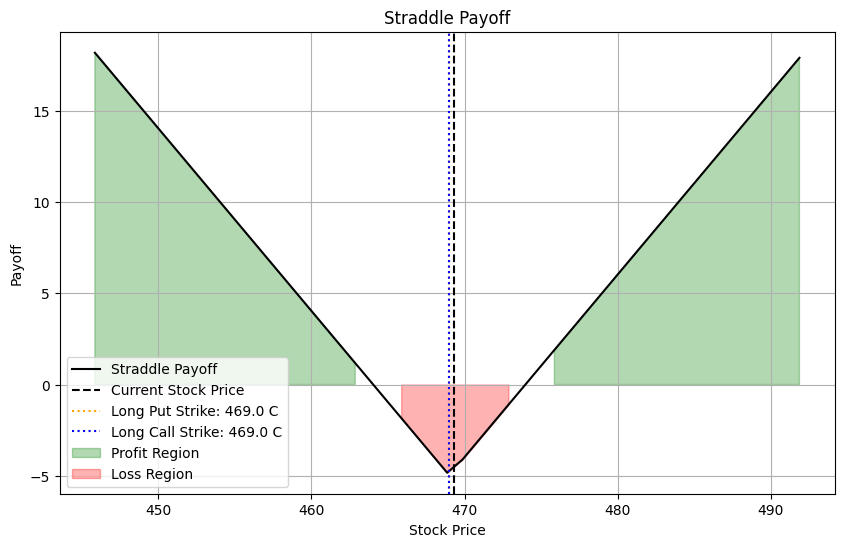

+----------+------------------+-----------------+-------------+----------+------------------+----------------+--------------+
| Strategy | Long Call Strike | Long Put Strike | Stock Price | Position | Potential Profit | Maximum Profit | Maximum Loss |
+----------+------------------+-----------------+-------------+----------+------------------+----------------+--------------+
|  Entry   |      469.0       |      469.0      |   469.33    |  -4.97   |                  |                |              |
| Bullish  |      469.0       |      469.0      |    492.8    |  26.26   |      2129.0      |   Unlimited    |    497.0     |
| Bearish  |      469.0       |      469.0      |   445.86    |  23.05   |      1808.0      |   Unlimited    |    497.0     |
|  Choppy  |      469.0       |      469.0      |   469.33    |    0     |      -497.0      |   Unlimited    |    497.0     |
+----------+------------------+-----------------+-------------+----------+------------------+----------------+--------

In [ ]:
# Straddle Entry
long_call_price_sd_entry, long_put_price_sd_entry, long_call_strike_sd_entry, long_put_strike_sd_entry, current_price_index = straddle(call_options_entry, put_options_entry, current_stock_price)
straddle_payoff = calculate_payoff2(stock_prices, current_stock_price, long_call_strike_sd_entry, long_put_strike_sd_entry, long_call_price_sd_entry, long_put_price_sd_entry)

# Straddle Bullish
long_call_price_sd_bullish, long_put_price_sd_bullish, _, _, _ = straddle(call_options_expiry, put_options_expiry, bullish_future_stock_price)

# Straddle Bearish
long_call_price_sd_bearish, long_put_price_sd_bearish, _, _, _ = straddle(call_options_expiry, put_options_expiry, bearish_future_stock_price)

# Straddle Choppy
long_call_price_sd_choppy, long_put_price_sd_choppy, _, _, _ = straddle(call_options_expiry, put_options_expiry, choppy_future_stock_price)

# Calculate Positions
initial_position_sd = (long_call_price_sd_entry + long_put_price_sd_entry).round(2) #premium paid
final_position_sd_bullish = (long_call_price_sd_bearish).round(2) #put expires worthless
final_position_sd_bearish = (long_put_price_sd_bullish).round(2) #long expires worthless
final_position_sd_choppy = 0 #both options expire worthless

# Calculate P&L
potential_profit_sd_bullish = ((final_position_sd_bullish - initial_position_sd) * 100).round(2)
potential_profit_sd_bearish = ((final_position_sd_bearish - initial_position_sd) * 100).round(2)
potential_profit_sd_choppy = ((final_position_sd_choppy - initial_position_sd) * 100).round(2)

maximum_profit_sd = "Unlimited" #long positions will print
maximum_loss_sd = (initial_position_sd * 100).round(2) #premium paid

# Plot the Combined Payoff Profile
stock_prices = np.arange(bearish_future_stock_price, bullish_future_stock_price, 1)

plt.figure(figsize=(10, 6))
plt.plot(stock_prices, straddle_payoff, label='Straddle Payoff', color='black')
plt.axvline(x=current_stock_price, linestyle='--', color='black', label='Current Stock Price')
plt.axvline(x=long_put_strike_sd_entry, linestyle='dotted', color='orange', label=f'Long Put Strike: {long_put_strike_sd_entry} C')
plt.axvline(x=long_call_strike_sd_entry, linestyle='dotted', color='blue', label=f'Long Call Strike: {long_call_strike_sd_entry} C')
plt.fill_between(stock_prices, straddle_payoff, where=(straddle_payoff > 1), color='green', alpha=0.3, label='Profit Region')
plt.fill_between(stock_prices, straddle_payoff, where=(straddle_payoff < -1), color='red', alpha=0.3, label='Loss Region')

plt.title('Straddle Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

# Display the Table
results_data = [
    ["Entry", long_call_strike_sd_entry, long_put_strike_sd_entry, current_stock_price, -initial_position_sd, ""],
    ["Bullish", long_call_strike_sd_entry, long_put_strike_sd_entry, bullish_future_stock_price, final_position_sd_bullish, potential_profit_sd_bullish, maximum_profit_sd, maximum_loss_sd],
    ["Bearish", long_call_strike_sd_entry, long_put_strike_sd_entry, bearish_future_stock_price, final_position_sd_bearish, potential_profit_sd_bearish, maximum_profit_sd, maximum_loss_sd],
    ["Choppy", long_call_strike_sd_entry, long_put_strike_sd_entry, choppy_future_stock_price, final_position_sd_choppy, potential_profit_sd_choppy, maximum_profit_sd, maximum_loss_sd],
]

table_headers = ["Strategy", "Long Call Strike", "Long Put Strike", "Stock Price", "Position", "Potential Profit", "Maximum Profit", "Maximum Loss"]
table = tabulate(results_data, headers=table_headers, tablefmt="pretty")
print(table)

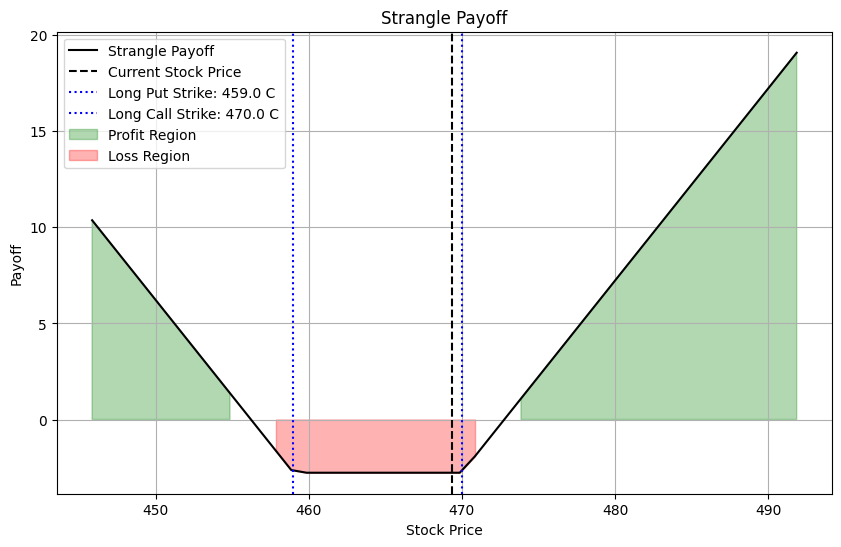

+----------+------------------+------------------+-------------+----------+------------------+----------------+--------------+
| Strategy | Long Call Strike |  Long Put Strike | Stock Price | Position | Potential Profit | Maximum Profit | Maximum Loss |
+----------+------------------+------------------+-------------+----------+------------------+----------------+--------------+
|  Entry   |      470.0       |      459.0       |   469.33    |  -2.77   |                  |                |              |
| Bullish  |      470.0       |      459.0       |    492.8    |  26.26   |      2349.0      |   Unlimited    |    277.0     |
| Bearish  |      470.0       |      459.0       |   445.86    |  23.05   |      2028.0      |   Unlimited    |    277.0     |
|  Choppy  |      470.0       |      459.0       |   469.33    |    0     |      -277.0      |   Unlimited    |    277.0     |
+----------+------------------+------------------+-------------+----------+------------------+----------------+

In [ ]:
# Strangle Entry
long_call_price_sg_entry, long_put_price_sg_entry, long_call_strike_sg_entry, long_put_strike_sg_entry, current_price_index = strangle(call_options_entry, put_options_entry, current_stock_price, stock_prices)
strangle_payoff = calculate_payoff2(stock_prices, current_stock_price, long_call_strike_sg_entry, long_put_strike_sg_entry, long_call_price_sg_entry, long_put_price_sg_entry)

# Strangle Bullish
long_call_price_sg_bullish, long_put_price_sg_bullish, _, _, _ = strangle(call_options_expiry, put_options_expiry, bullish_future_stock_price, stock_prices)

# Strangle Bearish
long_call_price_sg_bearish, long_put_price_sg_bearish, _, _, _ = strangle(call_options_expiry, put_options_expiry, bearish_future_stock_price, stock_prices)

# Strangle Choppy
long_call_price_sg_choppy, long_put_price_sg_choppy, _, _, _ = strangle(call_options_expiry, put_options_expiry, choppy_future_stock_price, stock_prices)

# Calculate Positions
initial_position_sg = (long_call_price_sg_entry + long_put_price_sg_entry).round(2) #premium paid
final_position_sg_bullish = (long_call_price_sg_bearish).round(2) #put expires worthless
final_position_sg_bearish = (long_put_price_sg_bullish).round(2) #long expires worthless
final_position_sg_choppy = 0 #both options expire worthless

# Calculate P&L
potential_profit_sg_bullish = ((final_position_sg_bullish - initial_position_sg) * 100).round(2)
potential_profit_sg_bearish = ((final_position_sg_bearish - initial_position_sg) * 100).round(2)
potential_profit_sg_choppy = ((final_position_sg_choppy - initial_position_sg) * 100).round(2)

maximum_profit_sg = "Unlimited"
maximum_loss_sg = (initial_position_sg * 100).round(2)

# Plot the Combined Payoff Profile
stock_prices = np.arange(bearish_future_stock_price, bullish_future_stock_price, 1)

plt.figure(figsize=(10, 6))
plt.plot(stock_prices, strangle_payoff, label='Strangle Payoff', color='black')
plt.axvline(x=current_stock_price, linestyle='--', color='black', label='Current Stock Price')
plt.axvline(x=long_put_strike_sg_entry, linestyle='dotted', color='blue', label=f'Long Put Strike: {long_put_strike_sg_entry} C')
plt.axvline(x=long_call_strike_sg_entry, linestyle='dotted', color='blue', label=f'Long Call Strike: {long_call_strike_sg_entry} C')
plt.fill_between(stock_prices, strangle_payoff, where=(strangle_payoff > 1), color='green', alpha=0.3, label='Profit Region')
plt.fill_between(stock_prices, strangle_payoff, where=(strangle_payoff < -1), color='red', alpha=0.3, label='Loss Region')


plt.title('Strangle Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

# Display the Table
results_data = [
        ["Entry", long_call_strike_sg_entry, long_put_strike_sg_entry, current_stock_price, -initial_position_sg, "", ""],
        ["Bullish", long_call_strike_sg_entry, long_put_strike_sg_entry, bullish_future_stock_price, final_position_sg_bullish, potential_profit_sg_bullish, maximum_profit_sg, maximum_loss_sg],
        ["Bearish", long_call_strike_sg_entry, long_put_strike_sg_entry, bearish_future_stock_price, final_position_sg_bearish, potential_profit_sg_bearish, maximum_profit_sg, maximum_loss_sg],
        ["Choppy", long_call_strike_sg_entry, long_put_strike_sg_entry, choppy_future_stock_price, final_position_sg_choppy, potential_profit_sg_choppy, maximum_profit_sg, maximum_loss_sg],
    ]

table_headers = ["Strategy", "Long Call Strike", " Long Put Strike", "Stock Price", "Position", "Potential Profit", "Maximum Profit", "Maximum Loss"]
table = tabulate(results_data, headers=table_headers, tablefmt="pretty")
print(table)

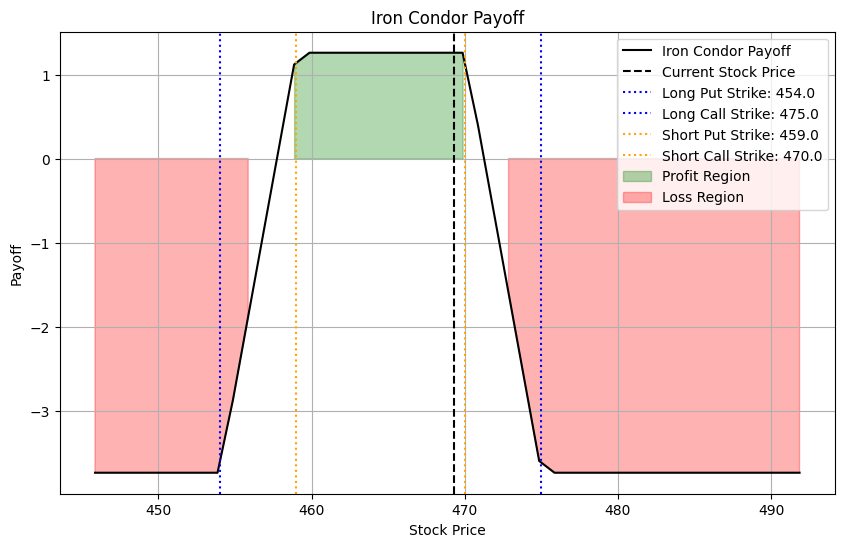

+----------+------------------+------------------+-------------------+------------------+-------------+----------+------------------+----------------+--------------+
| Strategy | Long Call Strike |  Long Put Strike | Short Call Strike | Short Put Strike | Stock Price | Position | Potential Profit | Maximum Profit | Maximum Loss |
+----------+------------------+------------------+-------------------+------------------+-------------+----------+------------------+----------------+--------------+
|  Entry   |      475.0       |      454.0       |       470.0       |      459.0       |   469.33    |   1.26   |                  |                |              |
| Bullish  |      475.0       |      454.0       |       470.0       |      459.0       |    492.8    |  -3.71   |      -245.0      |     126.0      |    -319.0    |
| Bearish  |      475.0       |      454.0       |       470.0       |      459.0       |   445.86    |  -4.45   |      -319.0      |     126.0      |    -319.0    |
|  C

In [ ]:
# Iron Condor Entry
long_call_price_ic_entry, long_put_price_ic_entry, short_call_price_ic_entry, short_put_price_ic_entry, long_call_strike_ic_entry, long_put_strike_ic_entry, short_call_strike_ic_entry, short_put_strike_ic_entry, current_price_index = iron_condor(call_options_entry, put_options_entry, current_stock_price, stock_prices)
iron_condor_payoff = calculate_payoff4(stock_prices, current_stock_price, long_call_strike_ic_entry, long_put_strike_ic_entry, short_call_strike_ic_entry, short_put_strike_ic_entry, long_call_price_ic_entry, long_put_price_ic_entry, short_call_price_ic_entry, short_put_price_ic_entry)

# Iron Condor Bullish
long_call_price_ic_bullish, long_put_price_ic_bullish, short_call_price_ic_bullish, short_put_price_ic_bullish, _, _, _, _, _ = iron_condor(call_options_expiry, put_options_expiry, bullish_future_stock_price, stock_prices)

# Iron Condor Bearish
long_call_price_ic_bearish, long_put_price_ic_bearish, short_call_price_ic_bearish, short_put_price_ic_bearish, _, _, _, _, _ = iron_condor(call_options_expiry, put_options_expiry, bearish_future_stock_price, stock_prices)

# Iron Condor Choppy
long_call_price_ic_choppy, long_put_price_ic_choppy, short_call_price_ic_choppy, short_put_price_ic_choppy, _, _, _, _, _ = iron_condor(call_options_expiry, put_options_expiry, choppy_future_stock_price, stock_prices)

# Calculate Positions
initial_position_ic = (long_call_price_ic_entry + long_put_price_ic_entry - short_call_price_ic_entry - short_put_price_ic_entry).round(2) #premium received
final_position_ic_bullish = (long_call_price_ic_bearish - short_call_price_ic_bearish).round(2) #puts expire worthless
final_position_ic_bearish = (long_put_price_ic_bullish - short_put_price_ic_bullish).round(2) #calls expire worthless
final_position_ic_choppy = 0 #options expire worthless

# Calculate P&L
potential_profit_ic_bullish = ((final_position_ic_bullish - initial_position_ic) * 100).round(2)
potential_profit_ic_bearish = ((final_position_ic_bearish - initial_position_ic) * 100).round(2)
potential_profit_ic_choppy = ((final_position_ic_choppy - initial_position_ic) * 100).round(2)

maximum_profit_ic = -(initial_position_ic * 100).round(2) #premium received
maximum_loss_ic = min(potential_profit_ic_bullish, potential_profit_ic_bearish).round(2)

# Plot the Combined Payoff Profile
stock_prices = np.arange(bearish_future_stock_price, bullish_future_stock_price, 1)

plt.figure(figsize=(10, 6))
plt.plot(stock_prices, iron_condor_payoff, label='Iron Condor Payoff', color='black')
plt.axvline(x=current_stock_price, linestyle='--', color='black', label='Current Stock Price')
plt.axvline(x=long_put_strike_ic_entry, linestyle='dotted', color='blue', label=f'Long Put Strike: {long_put_strike_ic_entry}')
plt.axvline(x=long_call_strike_ic_entry, linestyle='dotted', color='blue', label=f'Long Call Strike: {long_call_strike_ic_entry}')
plt.axvline(x=short_put_strike_ic_entry, linestyle='dotted', color='orange', label=f'Short Put Strike: {short_put_strike_ic_entry}')
plt.axvline(x=short_call_strike_ic_entry, linestyle='dotted', color='orange', label=f'Short Call Strike: {short_call_strike_ic_entry}')
plt.fill_between(stock_prices, iron_condor_payoff, where=(iron_condor_payoff > 1), color='green', alpha=0.3, label='Profit Region')
plt.fill_between(stock_prices, iron_condor_payoff, where=(iron_condor_payoff < -1), color='red', alpha=0.3, label='Loss Region')

plt.title('Iron Condor Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

# Display the Table
results_data = [
        ["Entry", long_call_strike_ic_entry, long_put_strike_ic_entry, short_call_strike_ic_entry, short_put_strike_ic_entry, current_stock_price, -initial_position_ic, "", ""],
        ["Bullish", long_call_strike_ic_entry, long_put_strike_ic_entry, short_call_strike_ic_entry, short_put_strike_ic_entry, bullish_future_stock_price, final_position_ic_bullish, potential_profit_ic_bullish, maximum_profit_ic, maximum_loss_ic],
        ["Bearish", long_call_strike_ic_entry, long_put_strike_ic_entry, short_call_strike_ic_entry, short_put_strike_ic_entry, bearish_future_stock_price, final_position_ic_bearish, potential_profit_ic_bearish, maximum_profit_ic, maximum_loss_ic],
        ["Choppy", long_call_strike_ic_entry, long_put_strike_ic_entry, short_call_strike_ic_entry, short_put_strike_ic_entry, choppy_future_stock_price, final_position_ic_choppy, potential_profit_ic_choppy, maximum_profit_ic, maximum_loss_ic],
    ]

table_headers = ["Strategy", "Long Call Strike", " Long Put Strike", "Short Call Strike", "Short Put Strike", "Stock Price", "Position", "Potential Profit", "Maximum Profit", "Maximum Loss"]
table = tabulate(results_data, headers=table_headers, tablefmt="pretty")
print(table)

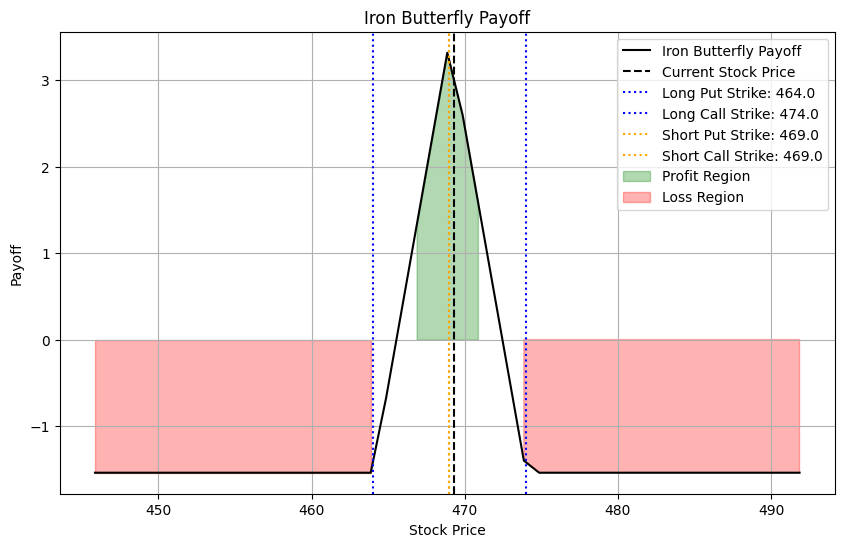

+----------+------------------+------------------+-------------------+------------------+-------------+----------+------------------+----------------+--------------+
| Strategy | Long Call Strike |  Long Put Strike | Short Call Strike | Short Put Strike | Stock Price | Position | Potential Profit | Maximum Profit | Maximum Loss |
+----------+------------------+------------------+-------------------+------------------+-------------+----------+------------------+----------------+--------------+
|  Entry   |      474.0       |      464.0       |       469.0       |      469.0       |   469.33    |   3.46   |                  |                |              |
| Bullish  |      474.0       |      464.0       |       469.0       |      469.0       |    492.8    |  -3.71   |      -25.0       |     346.0      |    -99.0     |
| Bearish  |      474.0       |      464.0       |       469.0       |      469.0       |   445.86    |  -4.45   |      -99.0       |     346.0      |    -99.0     |
|  C

In [ ]:
# Iron Butterfly Entry
long_call_price_ib_entry, long_put_price_ib_entry, short_call_price_ib_entry, short_put_price_ib_entry, long_call_strike_ib_entry, long_put_strike_ib_entry, short_call_strike_ib_entry, short_put_strike_ib_entry, current_price_index = iron_butterfly(call_options_entry, put_options_entry, current_stock_price, stock_prices)
iron_butterfly_payoff = calculate_payoff4(stock_prices, current_stock_price, long_call_strike_ib_entry, long_put_strike_ib_entry, short_call_strike_ib_entry, short_put_strike_ib_entry, long_call_price_ib_entry, long_put_price_ib_entry, short_call_price_ib_entry, short_put_price_ib_entry)

# Iron Butterfly Bullish
long_call_price_ib_bullish, long_put_price_ib_bullish, short_call_price_ib_bullish, short_put_price_ib_bullish, _, _, _, _, _ = iron_butterfly(call_options_expiry, put_options_expiry, bullish_future_stock_price, stock_prices)

# Iron Butterfly Bearish
long_call_price_ib_bearish, long_put_price_ib_bearish, short_call_price_ib_bearish, short_put_price_ib_bearish, _, _, _, _, _ = iron_butterfly(call_options_expiry, put_options_expiry, bearish_future_stock_price, stock_prices)

# Iron Butterfly Choppy
long_call_price_ib_choppy, long_put_price_ib_choppy, short_call_price_ib_choppy, short_put_price_ib_choppy, _, _, _, _, _ = iron_butterfly(call_options_expiry, put_options_expiry, choppy_future_stock_price, stock_prices)

# Calculate Positions
initial_position_ib = (long_call_price_ib_entry + long_put_price_ib_entry - short_call_price_ib_entry - short_put_price_ib_entry).round(2) #premium received
final_position_ib_bullish = (long_call_price_ib_bearish - short_call_price_ib_bearish).round(2) #puts expire worthless
final_position_ib_bearish = (long_put_price_ib_bullish - short_put_price_ib_bullish).round(2) #calls expire worthless
final_position_ib_choppy = 0 #options expire worthless

# Calculate P&L
potential_profit_ib_bullish = ((final_position_ib_bullish - initial_position_ib) * 100).round(2)
potential_profit_ib_bearish = ((final_position_ib_bearish - initial_position_ib) * 100).round(2)
potential_profit_ib_choppy = ((final_position_ib_choppy - initial_position_ib) * 100).round(2)

maximum_profit_ib = -(initial_position_ib * 100).round(2)
maximum_loss_ib = min(potential_profit_ib_bullish, potential_profit_ib_bearish).round(2)

# Plot the Combined Payoff Profile
stock_prices = np.arange(bearish_future_stock_price, bullish_future_stock_price, 1)

plt.figure(figsize=(10, 6))
plt.plot(stock_prices, iron_butterfly_payoff, label='Iron Butterfly Payoff', color='black')
plt.axvline(x=current_stock_price, linestyle='--', color='black', label='Current Stock Price')
plt.axvline(x=long_put_strike_ib_entry, linestyle='dotted', color='blue', label=f'Long Put Strike: {long_put_strike_ib_entry}')
plt.axvline(x=long_call_strike_ib_entry, linestyle='dotted', color='blue', label=f'Long Call Strike: {long_call_strike_ib_entry}')
plt.axvline(x=short_put_strike_ib_entry, linestyle='dotted', color='orange', label=f'Short Put Strike: {short_put_strike_ib_entry}')
plt.axvline(x=short_call_strike_ib_entry, linestyle='dotted', color='orange', label=f'Short Call Strike: {short_call_strike_ib_entry}')
plt.fill_between(stock_prices, iron_butterfly_payoff, where=(iron_butterfly_payoff > 1), color='green', alpha=0.3, label='Profit Region')
plt.fill_between(stock_prices, iron_butterfly_payoff, where=(iron_butterfly_payoff < -1), color='red', alpha=0.3, label='Loss Region')

plt.title('Iron Butterfly Payoff')
plt.xlabel('Stock Price')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

# Display the Table
results_data_ib = [
        ["Entry", long_call_strike_ib_entry, long_put_strike_ib_entry, short_call_strike_ib_entry, short_put_strike_ib_entry, current_stock_price, -initial_position_ib, "", ""],
        ["Bullish", long_call_strike_ib_entry, long_put_strike_ib_entry, short_call_strike_ib_entry, short_put_strike_ib_entry, bullish_future_stock_price, final_position_ib_bullish, potential_profit_ib_bullish, maximum_profit_ib, maximum_loss_ib],
        ["Bearish", long_call_strike_ib_entry, long_put_strike_ib_entry, short_call_strike_ib_entry, short_put_strike_ib_entry, bearish_future_stock_price, final_position_ib_bearish, potential_profit_ib_bearish, maximum_profit_ib, maximum_loss_ib],
        ["Choppy", long_call_strike_ib_entry, long_put_strike_ib_entry, short_call_strike_ib_entry, short_put_strike_ib_entry, choppy_future_stock_price, final_position_ib_choppy, potential_profit_ib_choppy, maximum_profit_ib, maximum_loss_ib],
    ]

table_headers_ib = ["Strategy", "Long Call Strike", " Long Put Strike", "Short Call Strike", "Short Put Strike", "Stock Price", "Position", "Potential Profit", "Maximum Profit", "Maximum Loss"]
table_ib = tabulate(results_data_ib, headers=table_headers_ib, tablefmt="pretty")
print(table_ib)

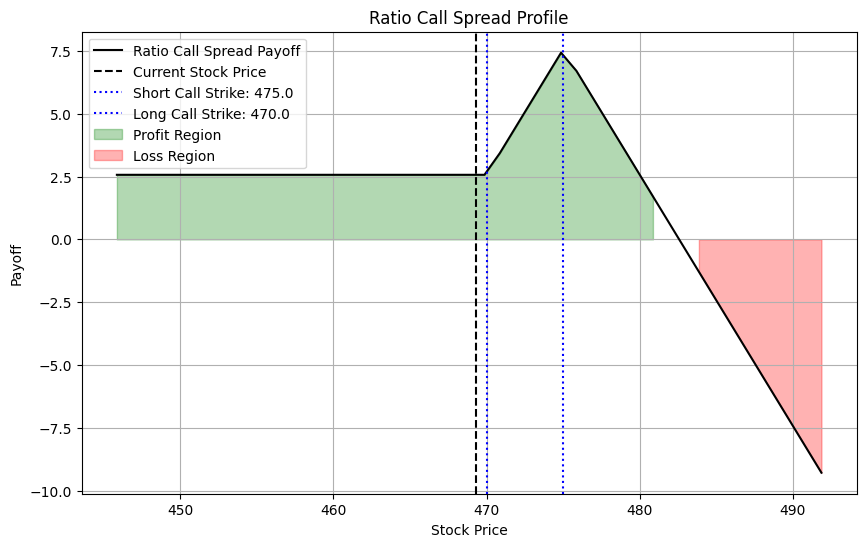

+----------+------------------+-------------------+-------------+----------+------------------+----------------+--------------+
| Strategy | Long Call Strike | Short Call Strike | Stock Price | Position | Potential Profit | Maximum Profit | Maximum Loss |
+----------+------------------+-------------------+-------------+----------+------------------+----------------+--------------+
|  Entry   |      470.0       |       475.0       |   469.33    |   2.57   |                  |                |              |
| Bullish  |      470.0       |       475.0       |    492.8    |  -26.26  |     -2369.0      |     1000.0     |  Unlimited   |
| Bearish  |      470.0       |       475.0       |   445.86    |    0     |      257.0       |     1000.0     |  Unlimited   |
|  Choppy  |      470.0       |       475.0       |   469.33    |   7.43   |      1000.0      |     1000.0     |  Unlimited   |
+----------+------------------+-------------------+-------------+----------+------------------+---------

In [ ]:
# Ratio Call Spread Entry
ratio = 2
long_call_price_rc_entry, short_call_price_rc_entry, long_call_strike_rc_entry, short_call_strike_rc_entry,  = ratio_call_spread(call_options_entry, current_stock_price, stock_prices, ratio)
ratio_call_spread_payoff = calculate_ratio_call_spread_payoff(stock_prices, current_stock_price, long_call_price_rc_entry, short_call_price_rc_entry, long_call_strike_rc_entry, short_call_strike_rc_entry, ratio)

# Ratio Call Spread Bullish
long_call_price_rc_bullish, short_call_price_rc_bullish, _, _ = ratio_call_spread(call_options_expiry, bullish_future_stock_price, stock_prices, ratio)

# Ratio Call Spread Bearish
long_call_price_rc_bearish, short_call_price_rc_bearish, _, _ = ratio_call_spread(call_options_expiry, bearish_future_stock_price, stock_prices, ratio)

# Ratio Call Spread Choppy
long_call_price_rc_choppy, short_call_price_rc_choppy, _, _ = ratio_call_spread(call_options_expiry, choppy_future_stock_price, stock_prices, ratio)

initial_position_rc_entry = long_call_price_rc_entry - short_call_price_rc_entry * ratio #premium received
final_position_rc_bullish = (long_call_price_rc_bearish - short_call_price_rc_bearish * ratio).round(2) #shorts give losses
final_position_rc_bearish = 0 #options expire worthless
final_position_rc_choppy = (short_call_price_rc_choppy * ratio - long_call_price_rc_choppy).round(2)

potential_profit_rc_bullish = ((final_position_rc_bullish - initial_position_rc_entry) * 100).round(2)
potential_profit_rc_bearish = ((final_position_rc_bearish - initial_position_rc_entry) * 100).round(2)
potential_profit_rc_choppy = ((final_position_rc_choppy - initial_position_rc_entry) * 100).round(2)

maximum_profit_rc = max(potential_profit_rc_bearish, potential_profit_rc_choppy)
maximum_loss_rc = "Unlimited"

# Plot the Combined Payoff Profile
stock_prices = np.arange(bearish_future_stock_price, bullish_future_stock_price, 1)

plt.figure(figsize=(10, 6))
plt.plot(stock_prices, ratio_call_spread_payoff, label='Ratio Call Spread Payoff', color='black')
plt.axvline(x=current_stock_price, linestyle='--', color='black', label='Current Stock Price')
plt.axvline(x=short_call_strike_rc_entry, linestyle='dotted', color='blue', label=f'Short Call Strike: {short_call_strike_rc_entry}')
plt.axvline(x=long_call_strike_rc_entry, linestyle='dotted', color='blue', label=f'Long Call Strike: {long_call_strike_rc_entry}')
plt.fill_between(stock_prices, ratio_call_spread_payoff, where=(ratio_call_spread_payoff >= 1), color='green', alpha=0.3, label='Profit Region')
plt.fill_between(stock_prices, ratio_call_spread_payoff, where=(ratio_call_spread_payoff <= -1), color='red', alpha=0.3, label='Loss Region')

plt.title('Ratio Call Spread Profile')
plt.xlabel('Stock Price')
plt.ylabel('Payoff')
plt.legend()
plt.grid(True)
plt.show()

# Display the Table
results_data = [
        ["Entry", long_call_strike_rc_entry, short_call_strike_rc_entry, current_stock_price, -initial_position_rc_entry, "", ""],
        ["Bullish", long_call_strike_rc_entry, short_call_strike_rc_entry, bullish_future_stock_price, final_position_rc_bullish, potential_profit_rc_bullish, maximum_profit_rc, maximum_loss_rc],
        ["Bearish", long_call_strike_rc_entry, short_call_strike_rc_entry, bearish_future_stock_price, final_position_rc_bearish, potential_profit_rc_bearish, maximum_profit_rc, maximum_loss_rc],
        ["Choppy", long_call_strike_rc_entry, short_call_strike_rc_entry, choppy_future_stock_price, final_position_rc_choppy, potential_profit_rc_choppy, maximum_profit_rc, maximum_loss_rc],
    ]

table_headers = ["Strategy", "Long Call Strike", "Short Call Strike", "Stock Price", "Position", "Potential Profit", "Maximum Profit", "Maximum Loss"]
table = tabulate(results_data, headers=table_headers, tablefmt="pretty")
print(table)

In [ ]:
from prettytable import PrettyTable

def create_results_table():
    table = PrettyTable()
    table.field_names = ["Strategy", "Long Call Strike", "Long Put Strike", "Short Call Strike", "Short Put Strike", "Current Stock Price", "Bullish Profit", "Bearish Profit", "Choppy Profit"]

    return table

def add_row_to_table(table, strategy_name, long_call_strike, long_put_strike, short_call_strike, short_put_strike, current_stock_price, bullish_profit, bearish_profit, choppy_profit):
    table.add_row([strategy_name, long_call_strike, long_put_strike, short_call_strike, short_put_strike, current_stock_price, bullish_profit, bearish_profit, choppy_profit])

def display_results_table(table):
    print(table)

# Example of how to use the table functions:

# Initialize the table
results_table = create_results_table()

# Add separator line
separator_line = ["-" * len(col) for col in results_table.field_names]

# Add rows for each strategy
add_row_to_table(results_table, "Straddle", long_call_strike_sd_entry, long_put_strike_sd_entry, "", "", current_stock_price, potential_profit_sd_bullish, potential_profit_sd_bearish, potential_profit_sd_choppy)
results_table.add_row(separator_line)
add_row_to_table(results_table, "Strangle", long_call_strike_sg_entry, long_put_strike_sg_entry, "", "", current_stock_price, potential_profit_sg_bullish, potential_profit_sg_bearish, potential_profit_sg_choppy)
results_table.add_row(separator_line)
add_row_to_table(results_table, "Iron Condor", long_call_strike_ic_entry, long_put_strike_ic_entry, short_call_strike_ic_entry, short_put_strike_ic_entry, current_stock_price, potential_profit_ic_bullish, potential_profit_ic_bearish, potential_profit_ic_choppy)
results_table.add_row(separator_line)
add_row_to_table(results_table, "Iron Butterfly", long_call_strike_ib_entry, long_put_strike_ib_entry, short_call_strike_ib_entry, short_put_strike_ib_entry, current_stock_price, potential_profit_ib_bullish, potential_profit_ib_bearish, potential_profit_ib_choppy)
results_table.add_row(separator_line)
add_row_to_table(results_table, "Ratio Call Spread", long_call_strike_rc_entry, "", short_call_strike_rc_entry, "", current_stock_price, potential_profit_rc_bullish, potential_profit_rc_bearish, potential_profit_rc_choppy)

# Display the table
display_results_table(results_table)


+-------------------+------------------+-----------------+-------------------+------------------+---------------------+----------------+----------------+---------------+
|      Strategy     | Long Call Strike | Long Put Strike | Short Call Strike | Short Put Strike | Current Stock Price | Bullish Profit | Bearish Profit | Choppy Profit |
+-------------------+------------------+-----------------+-------------------+------------------+---------------------+----------------+----------------+---------------+
|      Straddle     |      469.0       |      469.0      |                   |                  |        469.33       |     2129.0     |     1808.0     |     -497.0    |
|      --------     | ---------------- | --------------- | ----------------- | ---------------- | ------------------- | -------------- | -------------- | ------------- |
|      Strangle     |      470.0       |      459.0      |                   |                  |        469.33       |     2349.0     |     2028.0   